We are trying to explain the reason why there is difference in space and time with the baseline. Is it chance ? Or is it specific to space 
or time ?

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import os
import polars as pl

import random
random.seed(42)

import sys

sys.path.append('../')
sys.path.append('../src')
from functions.feat_network import get_edge_node_table, filter_edge_table
from functions.feat_visualization import sygma_graph
from functions.datamodel import OptimumParameter
from tqdm import tqdm
from sklearn.metrics import adjusted_rand_score
from dotenv import load_dotenv
import scipy.stats as stats

from functions.feat_network import get_edge_node_table, filter_edge_table
from functions.feat_visualization import sygma_graph
import random

In [2]:
pd.options.mode.chained_assignment = None

In [3]:
import sqlite3
import pandas as pd
import numpy as np
import os
import polars as pl

import random
random.seed(42)

import sys

sys.path.append('../')
sys.path.append('../src')
from functions.feat_network import get_edge_node_table, filter_edge_table
from functions.feat_visualization import sygma_graph
from functions.datamodel import OptimumParameter
from tqdm import tqdm
from sklearn.metrics import adjusted_rand_score
from dotenv import load_dotenv
import scipy.stats as stats


In [4]:
# Load the environment variables from the .env file
dotenv_path = os.path.join('../', '.env')
load_dotenv(dotenv_path)

True

In [5]:
conn = sqlite3.connect("../database.db")
conn_full_db = sqlite3.connect(os.getenv("FULL_DB_PATH"))



df_baseline = pd.read_sql("SELECT * FROM optimal_partition", conn)
df_baseline = df_baseline.rename(columns = {'community':'community_baseline'})

optimal_parameters = pd.read_sql("SELECT * FROM optimization", conn)
optimal_parameters = optimal_parameters.sort_values("mean", ascending=False)

dict_op = optimal_parameters.iloc[0].to_dict()
dict_op = OptimumParameter(**dict_op)

In [6]:
df_ind = pd.read_sql("SELECT * FROM individual_id_cleaned_occupations", conn)
all_individuals = list(set(df_ind.wikidata_id))

We compute different clusetring for different sizes of samples of individuals

In [7]:
df_ind_regions = pd.read_sql("SELECT * FROM temporal_data", conn)
df_ind_regions = df_ind_regions[['wikidata_id', 'region_code']].drop_duplicates()

For every region, compute the distance to the baseline ARI

In [8]:
#df_regions = pd.merge(df_regions, df_regions_name, on = 'region_code')
#df_regions

In [9]:
df_regions = pd.merge(df_ind_regions, df_ind, on = 'wikidata_id')

columns_to_keep = [
        "re_arabic_world",
        "re_central_europe",
        "re_chinese_world",
        "re_eastern_europe",
        "re_france",
        "re_german_world",
        "re_greek_world",
        "re_indian_world",
        "re_italy",
        "re_japan",
        "re_low_countries",
        "re_nordic_countries",
        "re_persian_world",
        "re_slav_world",
        "re_spain",
        "re_united_kingdom",
    ]

df_regions = df_regions[df_regions['region_code'].isin(columns_to_keep)]
df_regions_name = pd.read_sql_query(
        "SELECT * FROM regions", conn_full_db
    )

df_regions = pd.merge(df_regions, df_regions_name, on = 'region_code')
df_regions = df_regions.drop('region_code', axis=1)
df_regions = df_regions.rename(columns = {'region_name':'region_code'})

#data_all = pd.merge(data_all,df_regions, on = 'region_code')

final_list = []
for region in list(set(df_regions['region_code'])):

    
    df_sample = df_regions[df_regions['region_code']==region]
    df_sample = df_sample[['wikidata_id', 'meta_occupation']]
    
    len_individuals = len(set(df_sample['wikidata_id']))
    
    print(region, len_individuals)
    
    
    df_sample.columns = ["source", "target"]
    df_sample["weight"] = 1

    # Draw the graph
    df_sample = pl.from_pandas(df_sample)

    df_edge, df_nodes = get_edge_node_table(df_sample)

    df_edge_filter = filter_edge_table(
        df_edge,
        edge_rule=dict_op.edge_rule,
        top_directed_neighbours=dict_op.n_neighbours,
        normalize_on_top=False,
        min_count_link=0,
    )

    df_partition = sygma_graph(
        df_edge_filter,
        df_nodes,
        edge_bins=10,
        node_bins=10,
        resolution=dict_op.resolution,
        filepath="../cache/cache_graph.html",
    )    

    from sklearn.metrics import adjusted_rand_score

    new_df = pd.merge(df_baseline, df_partition, on = 'node', how ='outer')
    #new_df = pd.merge(df_baseline, df_partition, on = 'node')
    new_df = new_df.fillna(4)
    ari = adjusted_rand_score(list(new_df['community']), list(new_df['community_baseline']))
    
    final_list.append({'sample_length':len_individuals, 'ari':ari, 'region':region})
    
final_df = pd.DataFrame(final_list)

Japan 136
Slav world 966
Italy 1988
Chinese world 127
Spain 724
France 3670
Central Europe 2053
Eastern Europe 3563
German world 5638
United Kingdom 2958
Low countries 834
Indian world 40
Nordic countries 1378
Persian world 97
Greek World 242
Arabic world 201


Display the distance, add a regresion line and add labels

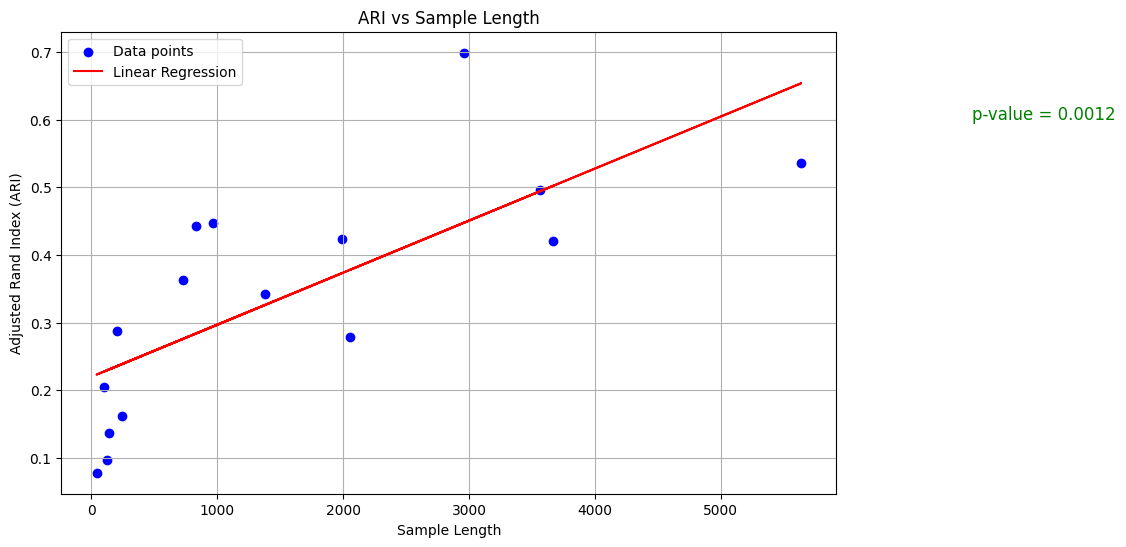

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression



plt.figure(figsize=(10, 6))
plt.scatter(final_df['sample_length'], final_df['ari'], color='b', label='Data points')
plt.title('ARI vs Sample Length')
plt.xlabel('Sample Length')
plt.ylabel('Adjusted Rand Index (ARI)')

# Linear regression
X = final_df[['sample_length']]
y = final_df['ari']

X = sm.add_constant(X)  # Adding a constant term to the predictor
model = sm.OLS(y, X).fit()

# Get the p-value from the model summary
p_value = model.pvalues[1]

y_pred = model.predict(X)
plt.plot(X['sample_length'], y_pred, color='r', label='Linear Regression')

# Display p-value on the plot
plt.text(7000, 0.6, f'p-value = {p_value:.4f}', fontsize=12, color='green')

plt.legend()
plt.grid(True)
plt.show()


Same plot with labels

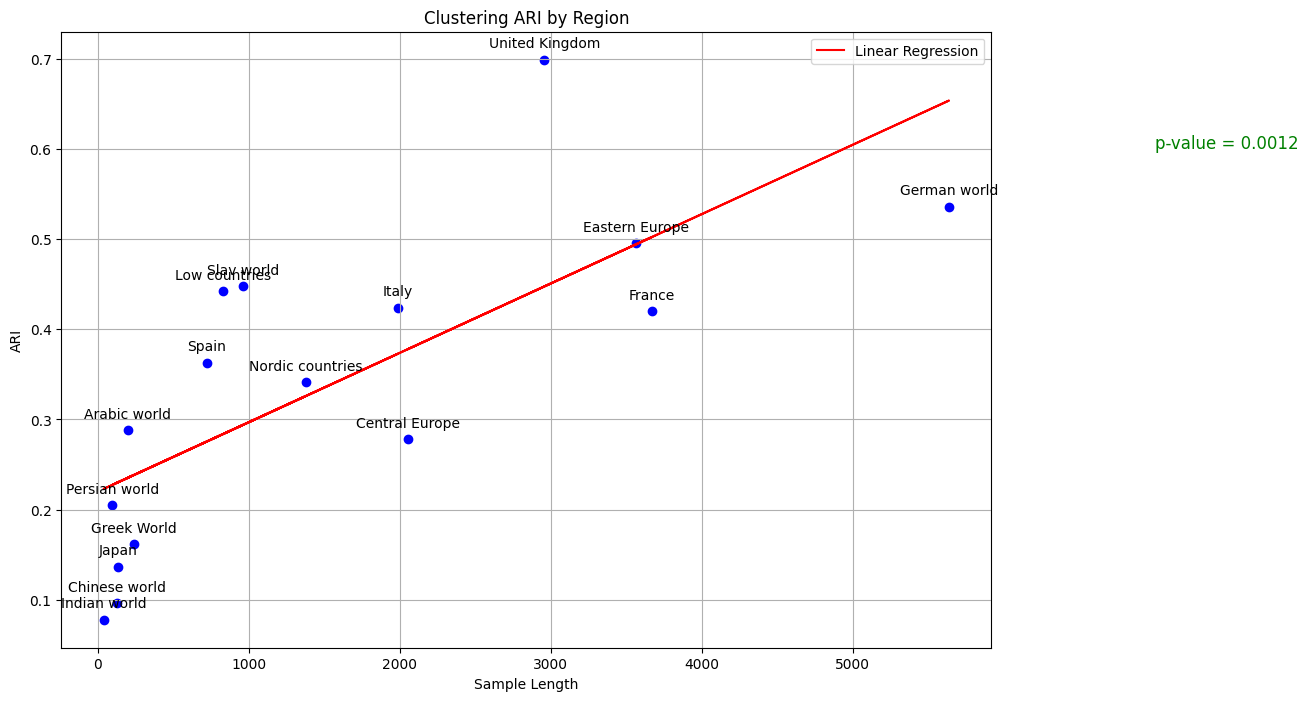

<Figure size 640x480 with 0 Axes>

In [11]:
sample_lengths = [entry for entry in final_df['sample_length']]
ari_values = [entry for entry in final_df['ari']]
regions = [entry for entry in final_df['region']]

# Create a scatter plot
plt.figure(figsize=(12, 8))
plt.scatter(sample_lengths, ari_values, color='blue')

# Add labels for each point
for i, region in enumerate(regions):
    plt.text(sample_lengths[i], ari_values[i]+0.01, region, fontsize=10, ha='center', va='bottom')

# Set plot labels and title
plt.xlabel('Sample Length')
plt.ylabel('ARI')
plt.title('Clustering ARI by Region')
plt.grid(True)

# Linear regression
X = final_df[['sample_length']]
y = final_df['ari']

X = sm.add_constant(X)  # Adding a constant term to the predictor
model = sm.OLS(y, X).fit()

# Get the p-value from the model summary
p_value = model.pvalues[1]

y_pred = model.predict(X)
plt.plot(X['sample_length'], y_pred, color='r', label='Linear Regression')

# Display p-value on the plot
plt.text(7000, 0.6, f'p-value = {p_value:.4f}', fontsize=12, color='green')

plt.legend()
plt.grid(True)
plt.show()


# Show the plot
plt.tight_layout()
plt.show()

Compute the same analysis with fake sample of the size of the countries

In [12]:
import random

list_individuals = list(set(df_regions.wikidata_id))

df_regions = pd.merge(df_ind_regions, df_ind, on = 'wikidata_id')


columns_to_keep = [
        "re_arabic_world",
        "re_central_europe",
        "re_chinese_world",
        "re_eastern_europe",
        "re_france",
        "re_german_world",
        "re_greek_world",
        "re_indian_world",
        "re_italy",
        "re_japan",
        "re_low_countries",
        "re_nordic_countries",
        "re_persian_world",
        "re_slav_world",
        "re_spain",
        "re_united_kingdom",
    ]

df_regions = df_regions[df_regions['region_code'].isin(columns_to_keep)]
df_regions_name = pd.read_sql_query(
        "SELECT * FROM regions", conn_full_db
    )

df_regions = pd.merge(df_regions, df_regions_name, on = 'region_code')
df_regions = df_regions.drop('region_code', axis=1)
df_regions = df_regions.rename(columns = {'region_name':'region_code'})


final_list = []
for region in list(set(df_regions['region_code'])):
    
    df_region_filter = df_regions[df_regions['region_code']==region]
    len_ind_region = len(set(df_region_filter['wikidata_id']))

    list_individuals_sample = random.sample(list_individuals, len_ind_region)
    df_sample = df_regions[df_regions['wikidata_id'].isin(list_individuals_sample)]
    df_sample = df_sample[['wikidata_id', 'meta_occupation']]
    
    len_individuals = len(set(df_sample['wikidata_id']))
    
    print(region, len_individuals)
    
    
    df_sample.columns = ["source", "target"]
    df_sample["weight"] = 1

    # Draw the graph
    df_sample = pl.from_pandas(df_sample)

    df_edge, df_nodes = get_edge_node_table(df_sample)

    df_edge_filter = filter_edge_table(
        df_edge,
        edge_rule=dict_op.edge_rule,
        top_directed_neighbours=dict_op.n_neighbours,
        normalize_on_top=False,
        min_count_link=0,
    )

    df_partition = sygma_graph(
        df_edge_filter,
        df_nodes,
        edge_bins=10,
        node_bins=10,
        resolution=dict_op.resolution,
        filepath="../cache/cache_graph.html",
    )    

    from sklearn.metrics import adjusted_rand_score

    new_df = pd.merge(df_baseline, df_partition, on = 'node', how ='outer')
    #new_df = pd.merge(df_baseline, df_partition, on = 'node')
    new_df = new_df.fillna(4)
    ari = adjusted_rand_score(list(new_df['community']), list(new_df['community_baseline']))
    
    final_list.append({'sample_length':len_individuals, 'ari':ari, 'region':region})
    
final_df_sample = pd.DataFrame(final_list)
final_df_sample['region'] = final_df_sample['region'] + '_sample'
final_df_sample = final_df_sample.rename(columns = {'ari':'ari_sample', 'region':'region_sample'})

Japan 136
Slav world 966
Italy 1988
Chinese world 127
Spain 724
France 3670
Central Europe 2053
Eastern Europe 3563
German world 5638
United Kingdom 2958
Low countries 834
Indian world 40
Nordic countries 1378
Persian world 97
Greek World 242
Arabic world 201


In [13]:
df_plot = pd.merge(final_df, final_df_sample, on = 'sample_length')

In [14]:
# Separate 'ari' and 'ari_sample' values into two lists
df_plot = df_plot.sort_values('sample_length')
ari_values = df_plot['ari']
ari_sample_values = df_plot['ari_sample']

# Perform a two-sample t-test
t_statistic, p_value = stats.ttest_rel(ari_values, ari_sample_values)

# Set the significance level
alpha = 0.05
t_statistic

1.1452368899414938

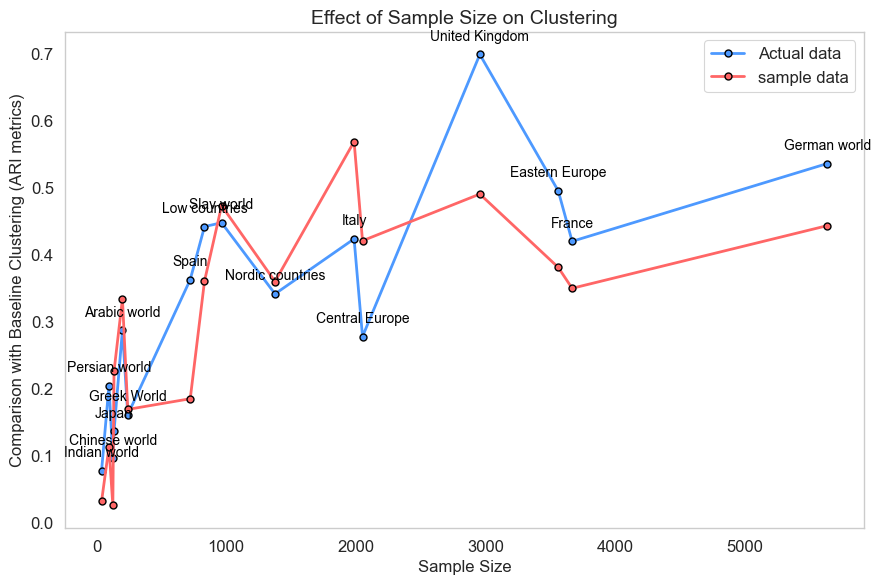

In [47]:
import matplotlib.pyplot as plt

# Extracting data from the DataFrame
sample_length = df_plot['sample_length']
ari = df_plot['ari']
ari_sample = df_plot['ari_sample']
region_sample = df_plot['region_sample']
region = df_plot['region']

import seaborn as sns  # Import seaborn for improved style

# Sort the DataFrame by 'sample_length'
df_plot = df_plot.sort_values(by='sample_length')

# Set the style using seaborn
sns.set(style="whitegrid", context="paper", font_scale=1.2)

# Create the figure and axis objects
fig, ax = plt.subplots(figsize=(9, 6))

# Define lighter colors
light_blue = (0.3, 0.6, 1.0)  # Light blue
light_red = (1.0, 0.4, 0.4)   # Light red

# Creating the line plot for 'ari' with a light blue color
#ax.plot(df_plot['sample_length'], df_plot['ari'], label='ari', color=light_blue, linestyle='-', linewidth=2)
ax.plot(df_plot['sample_length'], df_plot['ari'], label='ari', color=light_blue, linestyle='-', linewidth=2, marker='o', markersize=5, markeredgecolor='black', markeredgewidth=1, markerfacecolor=light_blue)


# Creating the line plot for 'ari_sample' with a light red color
#ax.plot(df_plot['sample_length'], df_plot['ari_sample'], label='ari_sample', color=light_red,linestyle='-', linewidth=2)
ax.plot(df_plot['sample_length'], df_plot['ari_sample'], label='ari_sample', color=light_red, linestyle='-', linewidth=2, marker='o', markersize=5, markeredgecolor='black', markeredgewidth=1, markerfacecolor=light_red)


# Adding labels and title
ax.set_xlabel('Sample Size', fontsize=12)
ax.set_ylabel('Comparison with Baseline Clustering (ARI metrics)', fontsize=12)
ax.set_title('Effect of Sample Size on Clustering', fontsize=14)

# Customize tick labels
ax.tick_params(axis='both', labelsize=12)
ax.grid(False)


# Add a legend
ax.legend(fontsize=12, loc='best', labels=['Actual data', 'sample data'])

# Add labels with region names on actual data points
for x, y_ari, y_ari_sample, region in zip(df_plot['sample_length'], df_plot['ari'], df_plot['ari_sample'], df_plot['region']):
    ax.annotate(region, (x, y_ari), textcoords="offset points", xytext=(0, 10), ha='center', fontsize=10, color='black')
    #ax.annotate(region, (x, y_ari_sample), textcoords="offset points", xytext=(0, -20), ha='center', fontsize=10, color='red')

# Adjust layout and save the plot as an image (optional)
plt.tight_layout()
plt.savefig('line_plot.png', dpi=300)  # Save the plot as an image

# Show the plot
plt.show()


In [16]:
df_ind_time = pd.read_sql("SELECT * FROM temporal_data", conn)
df_ind_time = df_ind_time[['wikidata_id', 'century']].drop_duplicates()
df_ind_time = df_ind_time.rename(columns = {'century':'time'})

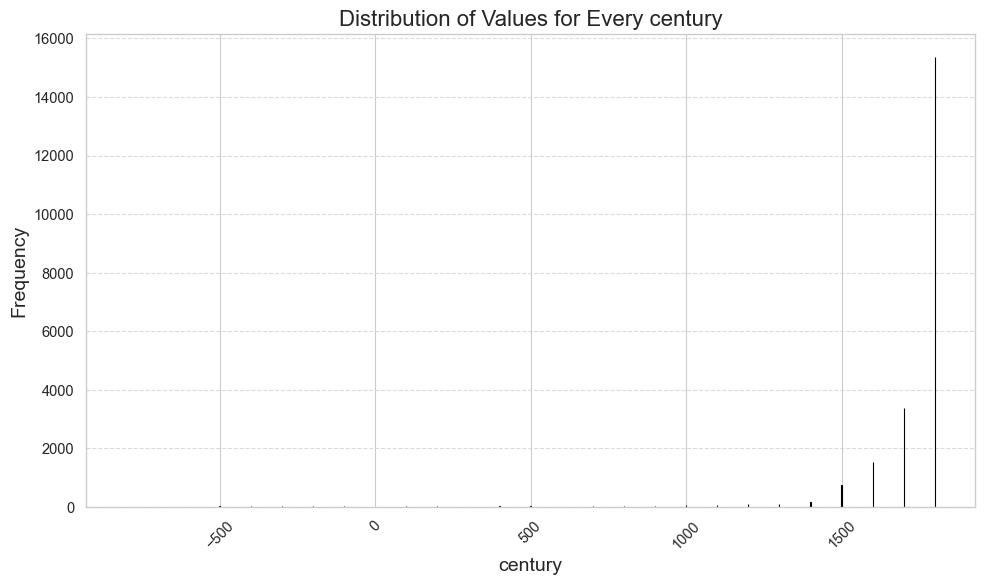

In [17]:
df_ind_time = df_ind_time[df_ind_time['time']<1850]

# Group the data by 'fifty' and count the occurrences
fifty_counts = df_ind_time['time'].value_counts().sort_index()

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(fifty_counts.index, fifty_counts.values, color='skyblue', edgecolor='black')
plt.xlabel('century', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Distribution of Values for Every century', fontsize=16)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

In [18]:
df_time =  pd.merge(df_ind_time, df_ind, on = 'wikidata_id')
df_time

,wikidata_id,time,meta_occupation
0,Q3136004,1800,botanist
1,Q85194,1800,botanist
2,Q123735,1800,astronomer
3,Q6288070,1800,astronomer
4,Q75994,1800,botanist
...,...,...,...
30949,Q12619924,1800,geographer
30950,Q494615,1400,astronomer
30951,Q11095247,1500,geographer
30952,Q485009,1700,geographer


In [19]:
final_list = []
for time in list(set(df_time['time'])):

    df_sample = df_time[df_time['time']==time]
    df_sample = df_sample[['wikidata_id', 'meta_occupation']]
    
    len_individuals = len(set(df_sample['wikidata_id']))
    
    print(time, len_individuals)
    
    
    df_sample.columns = ["source", "target"]
    df_sample["weight"] = 1

    # Draw the graph
    df_sample = pl.from_pandas(df_sample)

    df_edge, df_nodes = get_edge_node_table(df_sample)

    df_edge_filter = filter_edge_table(
        df_edge,
        edge_rule=dict_op.edge_rule,
        top_directed_neighbours=dict_op.n_neighbours,
        normalize_on_top=False,
        min_count_link=0,
    )

    df_partition = sygma_graph(
        df_edge_filter,
        df_nodes,
        edge_bins=10,
        node_bins=10,
        resolution=dict_op.resolution,
        filepath=f"../cache/cache_graph_{time}.html",
    )    

    from sklearn.metrics import adjusted_rand_score

    new_df = pd.merge(df_baseline, df_partition, on = 'node', how ='outer')
    #new_df = pd.merge(df_baseline, df_partition, on = 'node')
    new_df = new_df.fillna(4)
    ari = adjusted_rand_score(list(new_df['community']), list(new_df['community_baseline']))
    
    final_list.append({'sample_length':len_individuals, 'ari':ari, 'time':time})
    
final_df_time = pd.DataFrame(final_list)
final_df_time = final_df_time.sort_values('time')
final_df_time['log_size'] = np.log(final_df_time['sample_length']+1)

0 11
900 31
1800 15383
-500 22
400 19
1300 88
-100 21
800 41
1700 3378
-600 9
300 6
1200 93
-200 18
700 15
1600 1520
200 18
1100 59
-300 19
600 11
1500 754
-800 1
100 15
1000 56
-400 32
500 13
1400 168


Plot the first results

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


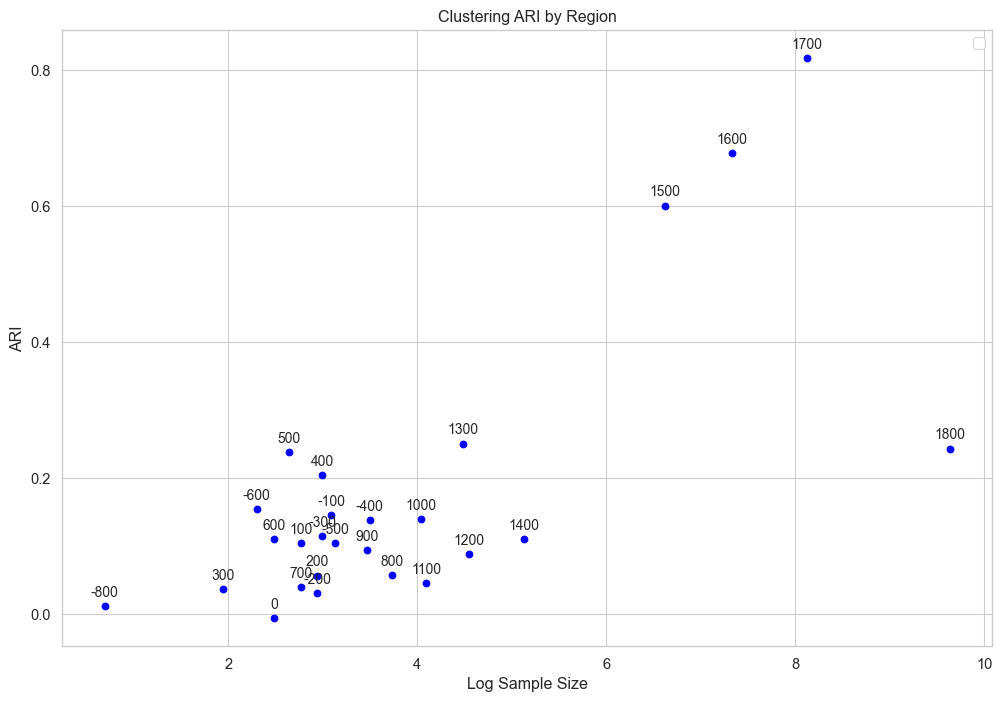

<Figure size 640x480 with 0 Axes>

In [20]:
sample_lengths = [entry for entry in final_df_time['log_size']]
ari_values = [entry for entry in final_df_time['ari']]
times = [entry for entry in final_df_time['time']]

# Create a scatter plot
plt.figure(figsize=(12, 8))
plt.scatter(sample_lengths, ari_values, color='blue')

# Add labels for each point
for i, time in enumerate(times):
    plt.text(sample_lengths[i], ari_values[i]+0.01, time, fontsize=10, ha='center', va='bottom')

# Set plot labels and title
plt.xlabel('Log Sample Size')
plt.ylabel('ARI')
plt.title('Clustering ARI by Region')
plt.grid(True)


plt.legend()
plt.grid(True)
plt.show()

# Show the plot
plt.tight_layout()
plt.show()

In [21]:
import random

list_individuals = list(set(df_time.wikidata_id))

In [22]:
final_list = []
for time in list(set(df_time['time'])):
    
    try:
    
        df_time_filter = df_time[df_time['time']==time]
        len_ind_time = len(set(df_time_filter['wikidata_id']))

        list_individuals_sample = random.sample(list_individuals, len_ind_time)
        df_sample = df_time[df_time['wikidata_id'].isin(list_individuals_sample)]
        df_sample = df_sample[['wikidata_id', 'meta_occupation']]

        len_individuals = len(set(df_sample['wikidata_id']))

        print(time, len_individuals)


        df_sample.columns = ["source", "target"]
        df_sample["weight"] = 1

        # Draw the graph
        df_sample = pl.from_pandas(df_sample)

        df_edge, df_nodes = get_edge_node_table(df_sample)

        df_edge_filter = filter_edge_table(
            df_edge,
            edge_rule=dict_op.edge_rule,
            top_directed_neighbours=dict_op.n_neighbours,
            normalize_on_top=False,
            min_count_link=0,
        )

        df_partition = sygma_graph(
            df_edge_filter,
            df_nodes,
            edge_bins=10,
            node_bins=10,
            resolution=dict_op.resolution,
            filepath="../cache/cache_graph.html",
        )    

        from sklearn.metrics import adjusted_rand_score

        new_df = pd.merge(df_baseline, df_partition, on = 'node', how ='outer')
        #new_df = pd.merge(df_baseline, df_partition, on = 'node')
        new_df = new_df.fillna(4)
        ari = adjusted_rand_score(list(new_df['community']), list(new_df['community_baseline']))

        final_list.append({'sample_length':len_individuals, 'ari':ari, 'time':time})
    except:
        pass
    
final_df_time_sample = pd.DataFrame(final_list)
final_df_time_sample = final_df_time_sample.sort_values('time')
final_df_time_sample = final_df_time_sample.rename(columns = {'ari':'ari_sample', 'time':'time_sample'})
df_plot_sample = pd.merge(final_df_time_sample, final_df_time, on = ['sample_length'])
df_plot_sample['log_size'] = np.log(df_plot_sample['sample_length']+1)

0 11
900 31
1800 15383
-500 22
400 19
1300 88
-100 21
800 41
1700 3378
-600 9
300 6
1200 93
-200 18
700 15
1600 1520
200 18
1100 59
-300 19
600 11
1500 754
-800 1
100 15
1000 56
-400 32
500 13
1400 168


Plot the T statistics

In [23]:

ari_values = df_plot_sample['ari']
ari_sample_values = df_plot_sample['ari_sample']

# Perform a two-sample t-test
t_statistic, p_value = stats.ttest_rel(ari_values, ari_sample_values)

# Set the significance level
alpha = 0.05
t_statistic

2.0671867751822615

In [24]:
p_value

0.04688480988931673

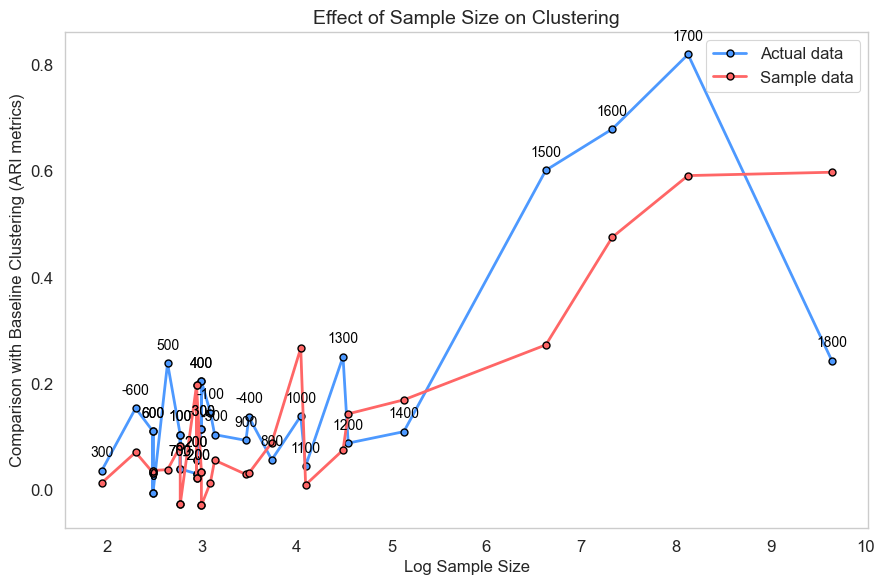

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns  # Import seaborn for improved style


# Extracting data from the DataFrame
log_size = df_plot_sample['log_size']
ari = df_plot_sample['ari']
ari_sample = df_plot_sample['ari_sample']
times_sample = df_plot_sample['time_sample']
times = df_plot_sample['time']

# Sort the DataFrame by 'sample_length'
df_plot_sample = df_plot_sample.sort_values(by='log_size')

# Set the style using seaborn
sns.set(style="whitegrid", context="paper", font_scale=1.2)

# Create the figure and axis objects
fig, ax = plt.subplots(figsize=(9, 6))

# Define lighter colors
light_blue = (0.3, 0.6, 1.0)  # Light blue
light_red = (1.0, 0.4, 0.4)   # Light red

# Creating the line plot for 'ari' with a light blue color
ax.plot(df_plot_sample['log_size'], df_plot_sample['ari'], label='ari', color=light_blue, linestyle='-', linewidth=2, marker='o', markersize=5, markeredgecolor='black', markeredgewidth=1, markerfacecolor=light_blue)


# Creating the line plot for 'ari_sample' with a light red color
ax.plot(df_plot_sample['log_size'], df_plot_sample['ari_sample'], label='ari_sample', color=light_red,linestyle='-', linewidth=2, marker='o', markersize=5, markeredgecolor='black', markeredgewidth=1, markerfacecolor=light_red)

# Adding labels and title
ax.set_xlabel('Log Sample Size', fontsize=12)
ax.set_ylabel('Comparison with Baseline Clustering (ARI metrics)', fontsize=12)
ax.set_title('Effect of Sample Size on Clustering', fontsize=14)

# Customize tick labels
ax.tick_params(axis='both', labelsize=12)
ax.grid(False)


# Add a legend
ax.legend(fontsize=12, loc='best', labels=['Actual data', 'Sample data'])

# Add labels with region names on actual data points
for x, y_ari, time in zip(df_plot_sample['log_size'], df_plot_sample['ari'], df_plot_sample['time']):
    ax.annotate(time, (x, y_ari), textcoords="offset points", xytext=(0, 10), ha='center', fontsize=10, color='black')
    #ax.annotate(region, (x, y_ari_sample), textcoords="offset points", xytext=(0, -20), ha='center', fontsize=10, color='red')

# Adjust layout and save the plot as an image (optional)
plt.tight_layout()
#plt.savefig('line_plot.png', dpi=300)  # Save the plot as an image

# Show the plot
plt.show()
